# 有限元求解二维非零边值泊松方程问题

求解二维possion方程
$$-\Delta u=f,     x\in\Omega$$
已知$$f=\left(\pi^2-1\right)\cdot\mathrm{e}^x\cdot\cos\left(\pi y\right)$$
边界条件
$$u\big|_{\Gamma_1}=p(x)=\mathrm{e}^x,
u\big|_{\Gamma_3}=q(x)=-\mathrm{e}^x$$

$$\frac{\partial u}{\partial\nu}\big|_{\Gamma_2}=m(y)=\mathrm{e}\cdot\cos(\pi y),
\frac{\partial u}{\partial\nu}\big|_{\Gamma_4}=n(y)=-\cos(\pi y)$$

其中$$\Omega\triangleq\left( 0,1\right) \times\left( 0,1\right)$$

$$\Gamma_1\triangleq\left\lbrace \left( x,0\right) \big| 0\leq x\leq1\right\rbrace,
\Gamma_3\triangleq\left\lbrace \left( x,1\right) \big| 0\leq x\leq1\right\rbrace$$

$$\Gamma_2\triangleq\left\lbrace \left( 1,y\right) \big| 0\leq y\leq1\right\rbrace,
\Gamma_4\triangleq\left\lbrace \left( 0,y\right) \big| 0\leq y\leq1\right\rbrace$$


解析解$$u=\mathrm{e}^x\cdot\cos\left(\pi y\right)$$

In [1]:
'''一些必要的模块'''
import numpy as np
# from fealpy.mesh.TriangleMesh import TriangleMesh
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
%matplotlib inline
# np.set_printoptions(threshold = 1e6)

In [2]:
'''正方形区域的均匀剖分'''
box = [0, 1, 0, 1]
nx = 64
ny = 64
NN = (nx+1) * (ny+1)
NC = nx * ny
node = np.zeros((NN, 2))
Y, X = np.mgrid[:box[1]:complex(nx+1), :box[3]:complex(ny+1)]
node[:, 0] = X.flatten() #按行取出矩阵X中的元素
node[:, 1] = Y.flatten()
cell = np.zeros((2*NC, 3), dtype = np.int)
sign = np.arange(NN).reshape(ny+1, nx+1)
cell[:NC, 0] = sign[0:-1, 1:].flatten() #每个小正方形下面的小三角形
cell[:NC, 1] = sign[1:, 1:].flatten()
cell[:NC, 2] = sign[0:-1, 0:-1].flatten()
cell[NC:, 0] = sign[1:, 0:-1].flatten() #每个小正方形上面的小三角形
cell[NC:, 1] = sign[0:-1, 0:-1].flatten()
cell[NC:, 2] = sign[1:, 1:].flatten()

In [3]:
'''生成基函数的梯度'''
v0 = node[cell[:, 2], :] - node[cell[:, 1], :] 
v1 = node[cell[:, 0], :] - node[cell[:, 2], :]
v2 = node[cell[:, 1], :] - node[cell[:, 0], :]
length = np.cross(v2, -v1)
Dlambda = np.zeros((2*NC, 3, 2), dtype = np.float)
W = np.array([[0, 1], [-1, 0]], dtype = np.int)
Dlambda[:, 0, :] = v0 @ W / length.reshape(-1, 1)
Dlambda[:, 1, :] = v1 @ W / length.reshape(-1, 1)
Dlambda[:, 2, :] = v2 @ W / length.reshape(-1, 1)

In [4]:
'''生成总刚度矩阵M'''
A = np.zeros((2*NC, 3, 3))
M = np.zeros((NN, NN))
for i in np.arange(2*NC):
    for j in np.arange(3):
        for k in np.arange(3):
            A[i, j, k] = np.dot(Dlambda[i][j], Dlambda[i][k]) * length[i] / 2
for i in np.arange(2*NC):
    for j in np.arange(3):
        for k in np.arange(3):
            M[cell[i][j], cell[i][k]] = M[cell[i][j], cell[i][k]] + A[i][j][k]            

In [5]:
'''生成载荷向量b'''
def p(x):
    p = np.exp(x)
    return p
def q(x):
    q = -np.exp(x)
    return q
def f(x,y):
    f = ((np.pi) ** 2 - 1) * np.exp(x) * np.cos(np.pi * y)
    return f
b = np.zeros(NN)
B = np.zeros((2*NC, 3))
for i in np.arange(2*NC):
    for j in np.arange(3):
        B[i,j] = f(node[cell[:, j], :][i][0], node[cell[:, j], :][i][1]) * length[i] / 6
for i in np.arange(2*NC):
    for j in np.arange(3):
        b[cell[i][j]] = b[cell[i][j]] + B[i][j]

In [6]:
'''生成边界项r'''
def m(y):
    m = np.exp(1) * np.cos(np.pi * y)
    return m
def n(y):
    n = -np.cos(np.pi * y)
    return n
r = np.zeros(NN)
R = np.zeros((2*NC, 2))
len = 1 / ny
for i in np.linspace(nx-1, NC-1, ny).astype(np.int):
    for j in np.arange(2):
        R[i,j] = m(node[cell[:, j], :][i][1]) * len / 2
for i in np.linspace(nx-1, NC-1, ny).astype(np.int):
    for j in np.arange(2):
        r[cell[i][j]] = r[cell[i][j]] + R[i][j]
R = np.zeros((2*NC, 2))
for i in np.linspace(NC, 2 * NC - nx, ny).astype(np.int):
    for j in np.arange(2):
        R[i,j] = n(node[cell[:, j], :][i][1]) * len / 2
for i in np.linspace(NC, 2 * NC - nx, ny).astype(np.int):
    for j in np.arange(2):
        r[cell[i][j]] = r[cell[i][j]] + R[i][j]
b+=r

In [7]:
'''找出边界节点'''
del_bound_down = np.arange(nx+1)
del_bound_up = np.arange(ny*(nx+1), (ny+1)*(nx+1))
del_bound = np.append(del_bound_down, del_bound_up)

In [8]:
'''计算已知边界值'''
U_bound_down = [p(node[k1][0])for k1 in del_bound_down]
U_bound_up = [q(node[k2][0])for k2 in del_bound_up]
U_bound = np.append(U_bound_down, U_bound_up)

In [9]:
'''更新总刚度矩阵M和载荷向量b'''
b-=np.dot(M[:,del_bound],U_bound)
b = np.delete(b,del_bound)
M_delRow = np.delete(M, del_bound, 0)
M_delCol = np.delete(M_delRow, del_bound, 1)
M = M_delCol

In [10]:
'''求解线性方程组得数值解'''
Uh = np.linalg.solve(M, b)
Uh_bound_down = [p(node[j1][0]) for j1 in del_bound_down]
Uh_bound_up = [q(node[j2][0]) for j2 in del_bound_up]
Uh = np.concatenate((Uh_bound_down, Uh, Uh_bound_up))

In [11]:
'''解析解在每个节点的函数值'''
def u(x,y):
    u = np.exp(x) * np.cos(np.pi * y)
    return u
u_real = np.zeros(NN)
for i in np.arange(NN):
    u_real[i] = u(node[i][0], node[i][1])

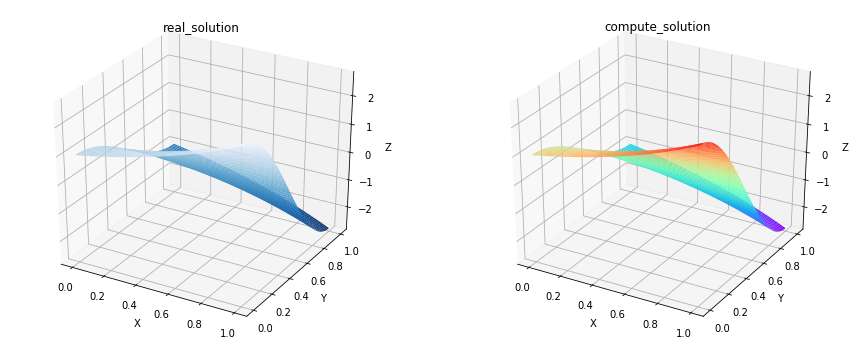

In [12]:
'''解析解和数值解的三维图形'''
u = np.exp(X) * np.cos(np.pi * Y)
fig = plt.figure(figsize = (15, 6))

ax = fig.add_subplot(1, 2, 1, projection = '3d')
figure = ax.plot_surface(X, Y, u, rstride=1, cstride=1, cmap = plt.cm.Blues_r)
ax.set_title("real_solution")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax = fig.add_subplot(1, 2, 2, projection = '3d')
figure = ax.plot_surface(X, Y, Uh.reshape((nx+1),(ny+1)), rstride=1, cstride=1, cmap='rainbow')
ax.set_title("compute_solution")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

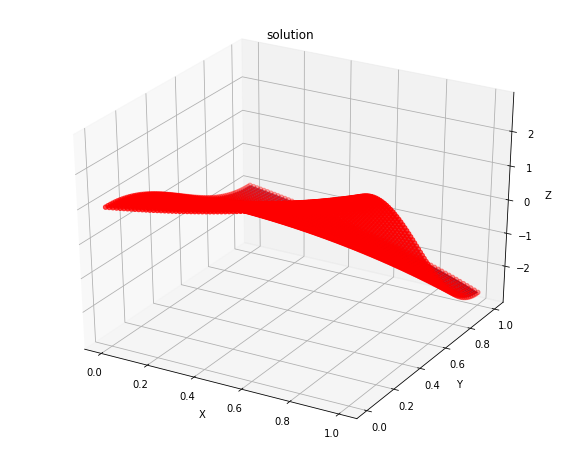

In [13]:
'''数值解离散点在解析解上的三维图'''
u = np.exp(X) * np.cos(np.pi * Y)
fig = plt.figure(figsize = (10, 8))

ax = fig.gca(projection = '3d')
figure1 = ax.plot_surface(X, Y, u, rstride=1, cstride=1, cmap=plt.cm.Blues_r)
figure2 = ax.scatter(X, Y, Uh.reshape((nx+1), (ny+1)), c='r')
ax.set_title("solution")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [14]:
'''误差的2范数'''
def u(x,y):
    u = np.exp(x) * np.cos(np.pi * y)
    return u
U_h = np.zeros((2*NC, 3))
for i in np.arange(2*NC):
    U_h[i,:] = Uh[cell[i, :]]
u_re_al = np.zeros((2*NC, 3))
for i in np.arange(2*NC):
    for j in np.arange(3):
        u_re_al[i, j] = u(node[cell[:, j], :][i][0], node[cell[:, j], :][i][1])
for i in np.arange(2*NC):
    e = ((u_re_al - U_h) ** 2 * length[i] / 6).sum()
    error = np.sqrt(e)
print(error)

5.23587808421581e-05


## error4=0.013497304713616655
## error8=0.0033755137927960065
## error16=0.0008394682189965492
## error32=0.0002095248696081579
## error64=5.23587808421581e-05

In [16]:
[error4 / error8, error8 / error16, error16 / error32, error32 / error64]

[3.998592671261629, 4.021014395078466, 4.006532592367089, 4.0017140628196834]